# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **data analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `dataproject.py` file includes a function which can be used multiple times in this notebook.

Imports and set magics:

In [ ]:
%pip install git+https://github.com/elben10/pydst
%pip install pandas-datareader
%pip install matplotlib-venn

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib_venn import venn2
import pandas_datareader
import pydst
import dataproject
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1 Introduction

From time to time articles appear in Danish media discussing the observed reductions in crime rates since the mid 90's. A possible confounder rarely discussed is the concurrent changes in the age structure of Danish society. Since the vast majority of violent('personfarlig') crime is commited by young men in the teens to the early twenties, this is potentially a serious confounder. In this short project, we examine how the age-corrected murder rate ('manddrab') has changed over time from 1980 to 2022. 

Why murder rate? Since both social and judicial definitions of violent crime have evolved over time, it is difficult to argue that increases in e.g. reported assaults or rapes directly reflect increases in objective incidence rates. Murder is in comparison a far more fixed entity, requiring a dead body and evidence of intentional homicide. 

Utilizing data from Danmarks Statistik on murder convictions and population age structure from 1980 to 2022, we compute age-specific murder rates for each year. We then find the specific age structure of the year 1980, expressed in fractions. These 1980 population age fractions are then scaled onto the age-specific murder rates in all years, producing the age-corrected murder rates that when summed for a given year reflect *what the murder rate would have been in a given year, had the population age structure in the given year been identical to the age structure of 1980*.  

### 2 Convictions as proxy for incidence

Given that we only have data on the characteristics of those convicted for murder, rather than on those that have perpetrated murder, there remains the issue of whether convictions are a sufficient proxy for incidence. Relevantly, since we are interested in the development over time of the murder rate, what could confound this development would lie in developments in the relationship between the conviction rate and the incidence rate, which would render the conviction rate a bad proxy for the incidence rate. As an example, police might have increased clearance rates over the period in question, which would bias results upwards (appearance of more murder over time). For this reason we plot the evolution in the number of murders minus the number of convictions for murder over the period in question


1.1. <a id='toc1_1_'></a>[Import og rensning af data for dømte for manddrab](#toc0_)

In [14]:
Dst = pydst.Dst(lang='da')

Dst.get_subjects()

tables = Dst.get_tables(subjects=['4'])

display(tables)

,id,text,unit,updated,firstPeriod,latestPeriod,active,variables
0,AUKS02,"Offentligt forsørgede (fuldtidsmodtagere, sæso...",Antal,2023-03-17 08:00:00,2007K1,2022K4,True,"[ydelsestype, køn, alder, tid]"
1,AUKS01,"Offentligt forsørgede (fuldtidsmodtagere, sæso...",Antal,2023-03-17 08:00:00,2007K1,2022K4,True,"[ydelsestype, tid]"
2,AUK01,Offentligt forsørgede (fuldtidsmodtagere),Antal,2023-03-17 08:00:00,2007K1,2022K4,True,"[område, ydelsestype, køn, alder, tid]"
3,AUK02,Offentligt forsørgede (fuldtidsmodtagere),Antal,2023-03-17 08:00:00,2007K1,2022K4,True,"[type, ydelsestype, alder, køn, tid]"
4,AUK03,Offentligt forsørgede (aktiverede fuldtidsmodt...,Antal,2023-03-17 08:00:00,2007K1,2022K4,True,"[område, ydelsestype, køn, alder, tid]"
...,...,...,...,...,...,...,...,...
266,LIVFO6,Livskvalitet,-,2016-11-07 09:00:00,2015,2015,True,"[dagligdag, enhed, formue, område, køn, tid]"
267,LIVFO7,Livskvalitet,-,2016-11-07 09:00:00,2015,2015,True,"[sociale relationer, enhed, formue, område, kø..."
268,LIVFO8,Livskvalitet,-,2016-11-07 09:00:00,2015,2015,True,"[økonomi, enhed, formue, område, køn, tid]"
269,LIVFO9,Livskvalitet,-,2016-11-07 09:00:00,2015,2015,True,"[tillid, enhed, formue, område, køn, tid]"


In [15]:

tables2 = Dst.get_variables(table_id='STRAF40')
tables2
print(tables2)


for id in ['OVERTRÆD']:
    print(id)
    values = tables2.loc[tables2.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

          id                text  elimination   time  \
0   OVERTRÆD  overtrædelsens art         True  False   
1  AFGØRELSE      afgørelsestype         True  False   
2      ALDER               alder         True  False   
3        KØN                 køn         True  False   
4        Tid                 tid        False   True   

                                              values  
0  [{'id': 'TOT', 'text': 'Overtrædelsens art i a...  
1  [{'id': '000', 'text': 'Afgørelsestype i alt'}...  
2  [{'id': 'TOT', 'text': 'Alder i alt'}, {'id': ...  
3  [{'id': 'TOT', 'text': 'I alt'}, {'id': 'M', '...  
4  [{'id': '1980', 'text': '1980'}, {'id': '1981'...  
OVERTRÆD
 id = TOT, text = Overtrædelsens art i alt
 id = 1, text = Straffelov i alt
 id = 1000, text = Uoplyst straffelov
 id = 11, text = Seksualforbrydelser i alt
 id = 1110, text = Blodskam mv.
 id = 1120, text = Voldtægt mv.
 id = 1130, text = Heteroseksuel sædelighedsforbrydelse mod barn under 12 år (Udgået 2013)
 id = 1131, 

In [4]:
variables = {'KØN':['M','K'], 'ALDER':['*'], 'AFGØRELSE':['1','2','511','516','517','518'],'Tid':['*'], 'OVERTRÆD':['1230']}
råstraf = Dst.get_data(table_id = 'STRAF40', variables=variables)
råstraf.sort_values(by=['KØN', 'ALDER', 'TID'], inplace=True)
del råstraf['AFGØRELSE']
del råstraf['OVERTRÆD']
display(råstraf)

,KØN,ALDER,TID,INDHOLD
346,Kvinder,15 år,1996,1
680,Kvinder,16 år,2015,1
703,Kvinder,16 år,2016,1
501,Kvinder,17 år,2004,1
518,Kvinder,17 år,2005,1
...,...,...,...,...
788,Mænd,Alder i alt,2020,7
804,Mænd,Alder i alt,2021,21
808,Mænd,Alder i alt,2021,3
819,Mænd,Alder i alt,2022,17


In [5]:

straf_sum = råstraf.groupby(['ALDER', 'TID']).sum(numeric_only=1)

display(straf_sum)

straf = pd.pivot_table(straf_sum, index = ['ALDER'], columns = ['TID'])

display(straf)

straf2 = straf.convert_dtypes()

straf2.info()

display(straf2)

print(straf2)



INDHOLD
ALDER       TID          
15 år       1996        1
16 år       1981        1
            1983        1
            1984        1
            1986        1
...                   ...
Alder i alt 2018       27
            2019       19
            2020       39
            2021       27
            2022       24

[451 rows x 1 columns]

INDHOLD                                                  \
TID                 1980  1981  1982  1983  1984  1985  1986  1987  1988   
ALDER                                                                      
15 år                NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
16 år                NaN   1.0   NaN   1.0   1.0   NaN   1.0   NaN   NaN   
17 år                NaN   1.0   NaN   NaN   NaN   NaN   NaN   1.0   NaN   
18 år                1.0   NaN   NaN   1.0   1.0   NaN   1.0   NaN   1.0   
19 år                NaN   2.0   2.0   1.0   1.0   NaN   2.0   2.0   NaN   
20 år                NaN   2.0   1.0   2.0   NaN   2.0   1.0   NaN   1.0   
21 år                2.0   2.0   2.0   1.0   NaN   NaN   2.0   1.0   NaN   
22 år                1.0   1.0   NaN   1.0   NaN   NaN   3.0   NaN   3.0   
23 år                NaN   4.0   NaN   1.0   NaN   1.0   NaN   1.0   1.0   
24 år                1.0   NaN   2.0   2.0   2.0   2.0   NaN   1.0   1.0   
25-29 år             6.0   4.0   6.0  10.0   6.0   9.0   4.0  10.0   6.0   
30-39 år             9.0   7.0  12.0   9.0  10.0   8.0  13.0   8.0  11.0   
40-49 år             2.0   4.0   5.0   6.0   9.0   4.0  11.0   3.0   5.0   
50-59 år             3.0   2.0   3.0   4.0   2.0   4.0   2.0   4.0   1.0   
60-69 år             1.0   2.0   NaN   1.0   2.0   NaN   2.0   3.0   NaN   
70-79 år             1.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
80 år og derover     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
Alder i alt         27.0  32.0  33.0  40.0  34.0  30.0  42.0  34.0  30.0   

                        ...                                                  \
TID               1989  ...  2013  2014  2015  2016  2017  2018  2019  2020   
ALDER                   ...                                                   
15 år              NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
16 år              NaN  ...   NaN   NaN   2.0   1.0   NaN   NaN   NaN   1.0   
17 år              NaN  ...   2.0   1.0   NaN   1.0   NaN   NaN   NaN   NaN   
18 år              NaN  ...   NaN   NaN   NaN   NaN   NaN   NaN   NaN   1.0   
19 år              1.0  ...   1.0   NaN   NaN   1.0   NaN   1.0   1.0   1.0   
20 år              NaN  ...   NaN   3.0   NaN   1.0   NaN   1.0   NaN   2.0   
21 år              NaN  ...   1.0   2.0   1.0   NaN   NaN   1.0   NaN   NaN   
22 år              1.0  ...   NaN   1.0   NaN   2.0   1.0   1.0   NaN   1.0   
23 år              4.0  ...   NaN   1.0   1.0   1.0   1.0   1.0   2.0   1.0   
24 år              2.0  ...   NaN   1.0   NaN   NaN   2.0   NaN   NaN   2.0   
25-29 år           4.0  ...   5.0   2.0   8.0   2.0   5.0   7.0   4.0   7.0   
30-39 år          12.0  ...   4.0   4.0  12.0   3.0   9.0   6.0   4.0   7.0   
40-49 år           5.0  ...  10.0   4.0   4.0   4.0   7.0   2.0   2.0   6.0   
50-59 år           2.0  ...   1.0   1.0   NaN   1.0   4.0   4.0   4.0   7.0   
60-69 år           1.0  ...   NaN   1.0   1.0   2.0   1.0   1.0   2.0   2.0   
70-79 år           NaN  ...   NaN   1.0   2.0   NaN   1.0   2.0   NaN   1.0   
80 år og derover   NaN  ...   NaN   NaN   1.0   NaN   NaN   NaN   NaN   NaN   
Alder i alt       32.0  ...  24.0  22.0  32.0  19.0  31.0  27.0  19.0  39.0   

                              
TID               2021  2022  
ALDER                         
15 år              NaN   NaN  
16 år              1.0   NaN  
17 år              NaN   NaN  
18 år              1.0   1.0  
19 år              1.0   NaN  
20 år              1.0   NaN  
21 år              1.0   1.0  
22 år              1.0   NaN  
23 år              NaN   2.0  
24 år              NaN   3.0  
25-29 år           6.0   6.0  
30-39 år           3.0   7.0  
40-49 år           4.0   2.0  
50-59 år           4.0   1.0  
60-69 år           1.0   1.0  
70-79 år           3.0   NaN  
80 år og derover   NaN   NaN  
Alder i alt       27.0  24.0  

[18 rows x 43 columns]

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 15 år to Alder i alt
Data columns (total 43 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   (INDHOLD, 1980)  11 non-null     Int64
 1   (INDHOLD, 1981)  13 non-null     Int64
 2   (INDHOLD, 1982)  9 non-null      Int64
 3   (INDHOLD, 1983)  14 non-null     Int64
 4   (INDHOLD, 1984)  10 non-null     Int64
 5   (INDHOLD, 1985)  8 non-null      Int64
 6   (INDHOLD, 1986)  12 non-null     Int64
 7   (INDHOLD, 1987)  11 non-null     Int64
 8   (INDHOLD, 1988)  10 non-null     Int64
 9   (INDHOLD, 1989)  10 non-null     Int64
 10  (INDHOLD, 1990)  9 non-null      Int64
 11  (INDHOLD, 1991)  9 non-null      Int64
 12  (INDHOLD, 1992)  9 non-null      Int64
 13  (INDHOLD, 1993)  12 non-null     Int64
 14  (INDHOLD, 1994)  9 non-null      Int64
 15  (INDHOLD, 1995)  11 non-null     Int64
 16  (INDHOLD, 1996)  13 non-null     Int64
 17  (INDHOLD, 1997)  12 non-null     Int64
 18  (IND

INDHOLD                                                  \
TID                 1980  1981  1982  1983  1984  1985  1986  1987  1988   
ALDER                                                                      
15 år               <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
16 år               <NA>     1  <NA>     1     1  <NA>     1  <NA>  <NA>   
17 år               <NA>     1  <NA>  <NA>  <NA>  <NA>  <NA>     1  <NA>   
18 år                  1  <NA>  <NA>     1     1  <NA>     1  <NA>     1   
19 år               <NA>     2     2     1     1  <NA>     2     2  <NA>   
20 år               <NA>     2     1     2  <NA>     2     1  <NA>     1   
21 år                  2     2     2     1  <NA>  <NA>     2     1  <NA>   
22 år                  1     1  <NA>     1  <NA>  <NA>     3  <NA>     3   
23 år               <NA>     4  <NA>     1  <NA>     1  <NA>     1     1   
24 år                  1  <NA>     2     2     2     2  <NA>     1     1   
25-29 år               6     4     6    10     6     9     4    10     6   
30-39 år               9     7    12     9    10     8    13     8    11   
40-49 år               2     4     5     6     9     4    11     3     5   
50-59 år               3     2     3     4     2     4     2     4     1   
60-69 år               1     2  <NA>     1     2  <NA>     2     3  <NA>   
70-79 år               1  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
80 år og derover    <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
Alder i alt           27    32    33    40    34    30    42    34    30   

                        ...                                                  \
TID               1989  ...  2013  2014  2015  2016  2017  2018  2019  2020   
ALDER                   ...                                                   
15 år             <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
16 år             <NA>  ...  <NA>  <NA>     2     1  <NA>  <NA>  <NA>     1   
17 år             <NA>  ...     2     1  <NA>     1  <NA>  <NA>  <NA>  <NA>   
18 år             <NA>  ...  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>     1   
19 år                1  ...     1  <NA>  <NA>     1  <NA>     1     1     1   
20 år             <NA>  ...  <NA>     3  <NA>     1  <NA>     1  <NA>     2   
21 år             <NA>  ...     1     2     1  <NA>  <NA>     1  <NA>  <NA>   
22 år                1  ...  <NA>     1  <NA>     2     1     1  <NA>     1   
23 år                4  ...  <NA>     1     1     1     1     1     2     1   
24 år                2  ...  <NA>     1  <NA>  <NA>     2  <NA>  <NA>     2   
25-29 år             4  ...     5     2     8     2     5     7     4     7   
30-39 år            12  ...     4     4    12     3     9     6     4     7   
40-49 år             5  ...    10     4     4     4     7     2     2     6   
50-59 år             2  ...     1     1  <NA>     1     4     4     4     7   
60-69 år             1  ...  <NA>     1     1     2     1     1     2     2   
70-79 år          <NA>  ...  <NA>     1     2  <NA>     1     2  <NA>     1   
80 år og derover  <NA>  ...  <NA>  <NA>     1  <NA>  <NA>  <NA>  <NA>  <NA>   
Alder i alt         32  ...    24    22    32    19    31    27    19    39   

                              
TID               2021  2022  
ALDER                         
15 år             <NA>  <NA>  
16 år                1  <NA>  
17 år             <NA>  <NA>  
18 år                1     1  
19 år                1  <NA>  
20 år                1  <NA>  
21 år                1     1  
22 år                1  <NA>  
23 år             <NA>     2  
24 år             <NA>     3  
25-29 år             6     6  
30-39 år             3     7  
40-49 år             4     2  
50-59 år             4     1  
60-69 år             1     1  
70-79 år             3  <NA>  
80 år og derover  <NA>  <NA>  
Alder i alt         27    24  

[18 rows x 43 columns]

                 INDHOLD                                                  \
TID                 1980  1981  1982  1983  1984  1985  1986  1987  1988   
ALDER                                                                      
15 år               <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>   
16 år               <NA>     1  <NA>     1     1  <NA>     1  <NA>  <NA>   
17 år               <NA>     1  <NA>  <NA>  <NA>  <NA>  <NA>     1  <NA>   
18 år                  1  <NA>  <NA>     1     1  <NA>     1  <NA>     1   
19 år               <NA>     2     2     1     1  <NA>     2     2  <NA>   
20 år               <NA>     2     1     2  <NA>     2     1  <NA>     1   
21 år                  2     2     2     1  <NA>  <NA>     2     1  <NA>   
22 år                  1     1  <NA>     1  <NA>  <NA>     3  <NA>     3   
23 år               <NA>     4  <NA>     1  <NA>     1  <NA>     1     1   
24 år                  1  <NA>     2     2     2     2  <NA>     1     1   
25-29 år    

1.2 Import og rensning af data for folketal

In [10]:
#Importerer BEFOLK1 fra statistikbanken
tables_folk = Dst.get_variables(table_id='BEFOLK1')
tables_folk
print(tables_folk)

#Undersøger værdierne af relevante variable
for id in ['ALDER', 'KØN']:
    print(id)
    values = tables_folk.loc[tables_folk.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

#Selektion af værdier for variable 
variables_folk = {'KØN':['1','2'],'ALDER':['>=15'], 'Tid':['>=1980']}
befolkning = Dst.get_data(table_id = 'BEFOLK1', variables=variables_folk)
befolkning.sort_values(by=['KØN', 'ALDER', 'TID'], inplace=True)
del befolkning['CIVILSTAND']

#Sletter karakterer efter et mellemrum og gør variablen numerisk (15 år bliver til 15)
befolkning['ALDER'] = befolkning['ALDER'].apply(lambda x: int(x.split(' ')[0]))

#Laver aldersintervaller, der matcher datasættet straf2
def age_buckets(x):
    if x == 15: 
        return '15 år'
    elif x == 16:
        return '16 år'
    elif x == 17:
        return '17 år'
    elif x == 18:
        return '18 år'
    elif x == 19:
        return '19 år'
    elif x == 20:
        return '20 år'
    elif x == 21:
        return '21 år'
    elif x == 22:
        return '22 år'
    elif x == 23:
        return '23 år'
    elif x == 24:
        return '24 år'
    elif x > 24 and x < 30:
        return '25-29 år'
    elif x < 40: 
        return '30-39 år' 
    elif x < 50: 
        return '40-49 år' 
    elif x < 60: 
        return '50-59 år' 
    elif x < 70: 
        return '60-69 år' 
    elif x < 80: 
        return '70-79 år' 
    elif x >=80: 
        return '80 år og derover' 
    else: return 'other'
befolkning['aldersinterval'] = befolkning.ALDER.apply(lambda x: age_buckets(x))
display(befolkning)
del befolkning['ALDER']

bef_sum = befolkning.groupby(['aldersinterval', 'TID']).sum(numeric_only=1)

display(bef_sum)
print(bef_sum)

#Nedenstående linje virker ikke med både columns og margins, men virker med kun index og column eller index og margins
bef = pd.pivot_table(bef_sum, index = ['aldersinterval'], columns = ['TID'])

display(bef)

bef2 = bef.convert_dtypes()

bef2.info()

display(bef2)


           id        text  elimination   time  \
0         KØN         køn         True  False   
1       ALDER       alder         True  False   
2  CIVILSTAND  civilstand         True  False   
3         Tid         tid        False   True   

                                              values  
0  [{'id': 'TOT', 'text': 'I alt'}, {'id': '1', '...  
1  [{'id': 'TOT', 'text': 'Alder i alt'}, {'id': ...  
2  [{'id': 'TOT', 'text': 'I alt'}, {'id': 'U', '...  
3  [{'id': '1971', 'text': '1971'}, {'id': '1972'...  
ALDER
 id = TOT, text = Alder i alt
 id = 0, text = 0 år
 id = 1, text = 1 år
 id = 2, text = 2 år
 id = 3, text = 3 år
 id = 4, text = 4 år
 id = 5, text = 5 år
 id = 6, text = 6 år
 id = 7, text = 7 år
 id = 8, text = 8 år
 id = 9, text = 9 år
 id = 10, text = 10 år
 id = 11, text = 11 år
 id = 12, text = 12 år
 id = 13, text = 13 år
 id = 14, text = 14 år
 id = 15, text = 15 år
 id = 16, text = 16 år
 id = 17, text = 17 år
 id = 18, text = 18 år
 id = 19, text = 19 år
 id

,KØN,ALDER,TID,INDHOLD,aldersinterval
7395,Kvinder,15,1980,39933,15 år
1625,Kvinder,15,1981,41152,15 år
5015,Kvinder,15,1982,42568,15 år
694,Kvinder,15,1983,39442,15 år
5185,Kvinder,15,1984,35923,15 år
...,...,...,...,...,...
3981,Mænd,99,2019,301,80 år og derover
4202,Mænd,99,2020,315,80 år og derover
6896,Mænd,99,2021,304,80 år og derover
7093,Mænd,99,2022,285,80 år og derover


INDHOLD
aldersinterval   TID          
15 år            1980    82114
                 1981    84428
                 1982    87253
                 1983    80577
                 1984    73967
...                        ...
80 år og derover 2019   263746
                 2020   272326
                 2021   282106
                 2022   291488
                 2023   304332

[748 rows x 1 columns]

                       INDHOLD
aldersinterval   TID          
15 år            1980    82114
                 1981    84428
                 1982    87253
                 1983    80577
                 1984    73967
...                        ...
80 år og derover 2019   263746
                 2020   272326
                 2021   282106
                 2022   291488
                 2023   304332

[748 rows x 1 columns]


INDHOLD                                                  \
TID                 1980    1981    1982    1983    1984    1985    1986   
aldersinterval                                                             
15 år              82114   84428   87253   80577   73967   71115   71062   
16 år              81265   82317   84493   87333   80743   74189   71410   
17 år              76616   81289   82329   84496   87411   80859   74424   
18 år              75478   76817   81383   82488   84612   87606   81104   
19 år              75330   75424   76532   81138   82224   84440   87401   
20 år              73218   75333   75364   76568   81303   82523   84940   
21 år              74043   73194   75281   75388   76709   81497   82968   
22 år              74277   73846   73065   75254   75565   76871   81942   
23 år              75190   74111   73732   73005   75258   75610   77430   
24 år              75020   75084   74006   73661   72993   75366   76119   
25-29 år          374797  372788  373292  372349  370260  369801  372681   
30-39 år          780291  791793  798578  799091  797000  787446  775613   
40-49 år          567670  574373  583577  600116  621486  647719  677319   
50-59 år          564411  553724  544403  539498  532945  528377  525740   
60-69 år          502112  505892  507775  504971  503735  502433  502092   
70-79 år          346521  352410  357138  362378  366818  370156  370562   
80 år og derover  142281  146296  150640  155850  159726  164385  168336   

                                          ...                                  \
TID                 1987    1988    1989  ...    2014    2015    2016    2017   
aldersinterval                            ...                                   
15 år              75109   75463   71950  ...   68174   68119   69127   67555   
16 år              71374   75402   75693  ...   70073   68822   68772   69839   
17 år              71753   71565   75430  ...   70507   70306   69287   69260   
18 år              74925   72072   71691  ...   73255   70973   71131   70008   
19 år              81301   74846   71571  ...   74737   74684   72647   72688   
20 år              88033   81564   74744  ...   73470   76210   76989   74572   
21 år              85488   88291   81491  ...   75528   74883   78470   78567   
22 år              83526   85630   88133  ...   73075   76460   76602   79900   
23 år              82438   83640   85461  ...   73849   74419   78420   78399   
24 år              77932   82518   83640  ...   72352   75068   76268   79884   
25-29 år          375024  378750  386330  ...  333707  346358  361983  374117   
30-39 år          762469  751147  744276  ...  687825  678734  673593  673969   
40-49 år          707558  732731  750799  ...  809755  803208  797159  781712   
50-59 år          525348  527870  531315  ...  737542  750878  765248  781703   
60-69 år          500738  498093  494897  ...  694294  688697  681207  672152   
70-79 år          370646  370596  370268  ...  435531  459840  486316  513155   
80 år og derover  173178  177792  182785  ...  234891  239409  243758  249721   

                                                                  
TID                 2018    2019    2020    2021    2022    2023  
aldersinterval                                                    
15 år              66614   67512   67768   67877   69009   69038  
16 år              68201   67142   67948   68246   68420   70187  
17 år              70115   68260   67304   68088   68469   69155  
18 år              69781   70566   68639   67674   68674   69597  
19 år              71269   70935   71623   69581   69151   69946  
20 år              74585   72820   72131   72666   71267   70877  
21 år              76294   75806   73901   72840   74538   73294  
22 år              79720   77306   76462   74517   74686   76532  
23 år              81298   80841   78029   77321   76345   76634  
24 år              79675   82217   81368   78560   78611   78041  
25-2

<class 'pandas.core.frame.DataFrame'>
Index: 17 entries, 15 år to 80 år og derover
Data columns (total 44 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   (INDHOLD, 1980)  17 non-null     Int64
 1   (INDHOLD, 1981)  17 non-null     Int64
 2   (INDHOLD, 1982)  17 non-null     Int64
 3   (INDHOLD, 1983)  17 non-null     Int64
 4   (INDHOLD, 1984)  17 non-null     Int64
 5   (INDHOLD, 1985)  17 non-null     Int64
 6   (INDHOLD, 1986)  17 non-null     Int64
 7   (INDHOLD, 1987)  17 non-null     Int64
 8   (INDHOLD, 1988)  17 non-null     Int64
 9   (INDHOLD, 1989)  17 non-null     Int64
 10  (INDHOLD, 1990)  17 non-null     Int64
 11  (INDHOLD, 1991)  17 non-null     Int64
 12  (INDHOLD, 1992)  17 non-null     Int64
 13  (INDHOLD, 1993)  17 non-null     Int64
 14  (INDHOLD, 1994)  17 non-null     Int64
 15  (INDHOLD, 1995)  17 non-null     Int64
 16  (INDHOLD, 1996)  17 non-null     Int64
 17  (INDHOLD, 1997)  17 non-null     Int64
 18 

INDHOLD                                                  \
TID                 1980    1981    1982    1983    1984    1985    1986   
aldersinterval                                                             
15 år              82114   84428   87253   80577   73967   71115   71062   
16 år              81265   82317   84493   87333   80743   74189   71410   
17 år              76616   81289   82329   84496   87411   80859   74424   
18 år              75478   76817   81383   82488   84612   87606   81104   
19 år              75330   75424   76532   81138   82224   84440   87401   
20 år              73218   75333   75364   76568   81303   82523   84940   
21 år              74043   73194   75281   75388   76709   81497   82968   
22 år              74277   73846   73065   75254   75565   76871   81942   
23 år              75190   74111   73732   73005   75258   75610   77430   
24 år              75020   75084   74006   73661   72993   75366   76119   
25-29 år          374797  372788  373292  372349  370260  369801  372681   
30-39 år          780291  791793  798578  799091  797000  787446  775613   
40-49 år          567670  574373  583577  600116  621486  647719  677319   
50-59 år          564411  553724  544403  539498  532945  528377  525740   
60-69 år          502112  505892  507775  504971  503735  502433  502092   
70-79 år          346521  352410  357138  362378  366818  370156  370562   
80 år og derover  142281  146296  150640  155850  159726  164385  168336   

                                          ...                                  \
TID                 1987    1988    1989  ...    2014    2015    2016    2017   
aldersinterval                            ...                                   
15 år              75109   75463   71950  ...   68174   68119   69127   67555   
16 år              71374   75402   75693  ...   70073   68822   68772   69839   
17 år              71753   71565   75430  ...   70507   70306   69287   69260   
18 år              74925   72072   71691  ...   73255   70973   71131   70008   
19 år              81301   74846   71571  ...   74737   74684   72647   72688   
20 år              88033   81564   74744  ...   73470   76210   76989   74572   
21 år              85488   88291   81491  ...   75528   74883   78470   78567   
22 år              83526   85630   88133  ...   73075   76460   76602   79900   
23 år              82438   83640   85461  ...   73849   74419   78420   78399   
24 år              77932   82518   83640  ...   72352   75068   76268   79884   
25-29 år          375024  378750  386330  ...  333707  346358  361983  374117   
30-39 år          762469  751147  744276  ...  687825  678734  673593  673969   
40-49 år          707558  732731  750799  ...  809755  803208  797159  781712   
50-59 år          525348  527870  531315  ...  737542  750878  765248  781703   
60-69 år          500738  498093  494897  ...  694294  688697  681207  672152   
70-79 år          370646  370596  370268  ...  435531  459840  486316  513155   
80 år og derover  173178  177792  182785  ...  234891  239409  243758  249721   

                                                                  
TID                 2018    2019    2020    2021    2022    2023  
aldersinterval                                                    
15 år              66614   67512   67768   67877   69009   69038  
16 år              68201   67142   67948   68246   68420   70187  
17 år              70115   68260   67304   68088   68469   69155  
18 år              69781   70566   68639   67674   68674   69597  
19 år              71269   70935   71623   69581   69151   69946  
20 år              74585   72820   72131   72666   71267   70877  
21 år              76294   75806   73901   72840   74538   73294  
22 år              79720   77306   76462   74517   74686   76532  
23 år              81298   80841   78029   77321   76345   76634  
24 år              79675   82217   81368   78560   78611   78041  
25-2

1.3 Beregning af mordrate

In [11]:
mordrate = straf2.div(bef2)*100000 #Mord pr 100.000 indbygger
display(mordrate)

INDHOLD                                                    \
TID                   1980      1981      1982      1983      1984      1985   
15 år                 <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   
16 år                 <NA>  1.214816      <NA>  1.145043  1.238497      <NA>   
17 år                 <NA>  1.230179      <NA>      <NA>      <NA>      <NA>   
18 år             1.324889      <NA>      <NA>  1.212298  1.181865      <NA>   
19 år                 <NA>  2.651676  2.613286  1.232468   1.21619      <NA>   
20 år                 <NA>  2.654879  1.326893  2.612057      <NA>  2.423567   
21 år             2.701133  2.732464  2.656713  1.326471      <NA>      <NA>   
22 år             1.346312  1.354169      <NA>  1.328833      <NA>      <NA>   
23 år                 <NA>  5.397309      <NA>  1.369769      <NA>  1.322576   
24 år             1.332978      <NA>  2.702484  2.715141  2.739989  2.653717   
25-29 år          1.600867  1.072996  1.607321  2.685652  1.620483  2.433741   
30-39 år          1.153416  0.884069  1.502671   1.12628  1.254705  1.015943   
40-49 år          0.352317  0.696412  0.856785  0.999807  1.448142  0.617552   
50-59 år          0.531528  0.361191  0.551062   0.74143  0.375273  0.757035   
60-69 år          0.199159  0.395341      <NA>  0.198031  0.397034      <NA>   
70-79 år          0.288583      <NA>      <NA>      <NA>      <NA>      <NA>   
80 år og derover      <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   
Alder i alt           <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   

                                                          ...            \
TID                   1986      1987      1988      1989  ...      2014   
15 år                 <NA>      <NA>      <NA>      <NA>  ...      <NA>   
16 år             1.400364      <NA>      <NA>      <NA>  ...      <NA>   
17 år                 <NA>   1.39367      <NA>      <NA>  ...  1.418299   
18 år             1.232985      <NA>  1.387501      <NA>  ...      <NA>   
19 år             2.288303  2.459994      <NA>  1.397214  ...      <NA>   
20 år             1.177302      <NA>  1.226031      <NA>  ...  4.083299   
21 år             2.410568  1.169755      <NA>      <NA>  ...  2.648025   
22 år             3.661126      <NA>  3.503445  1.134649  ...  1.368457   
23 år                 <NA>  1.213033    1.1956  4.680498  ...  1.354114   
24 år                 <NA>   1.28317  1.211857    2.3912  ...  1.382132   
25-29 år          1.073304  2.666496  1.584158  1.035384  ...  0.599328   
30-39 år          1.676094  1.049223  1.464427  1.612305  ...  0.581543   
40-49 år           1.62405  0.423994  0.682379  0.665957  ...  0.493977   
50-59 år          0.380416    0.7614  0.189441  0.376425  ...  0.135585   
60-69 år          0.398333  0.599116      <NA>  0.202062  ...  0.144031   
70-79 år              <NA>      <NA>      <NA>      <NA>  ...  0.229605   
80 år og derover      <NA>      <NA>      <NA>      <NA>  ...      <NA>   
Alder i alt           <NA>      <NA>      <NA>      <NA>  ...      <NA>   

                                                                              \
TID                   2015      2016      2017      2018      2019      2020   
15 år                 <NA>      <NA>      <NA>      <NA>      <NA>      <NA>   
16 år             2.906047   1.45408      <NA>      <NA>      <NA>  1.471714   
17 år                 <NA>  1.443272      <NA>      <NA>      <NA>      <NA>   
18 år                 <NA>      <NA>      <NA>      <NA>      <NA>  1.456898   
19 år                 <NA>  1.376519      <NA>  1.403135  1.409741    1.3962   
20 år                 <NA>  1.298887      <NA>  1.340752      <NA>  2.772733   
21 år             1.335417      <NA>      <NA>  1.310719      <NA>      <NA>   
22 år                 <NA>  2.610898  1.251564   1.25439      <NA>  1.307839   
23 år             1.343743  1.275185  1.275526  1.230043  2.473992  1.281575   
24 år                 <NA>      <NA> 

1.3 Udviklingen i relationen mellem anmeldte og dømte for manddrab

In [17]:
tables3 = Dst.get_variables(table_id='STRAF20')
tables3
print(tables3)


for id in ['ANMSIGT']:
    print(id)
    values = tables3.loc[tables3.id == id,['values']].values[0,0]
    for value in values:      
        print(f' id = {value["id"]}, text = {value["text"]}')

variables2 = {'ANMSIGT':['ANM'],'OVERTRÆD':['1230'], 'Tid':['*']}
anmeldte = Dst.get_data(table_id = 'STRAF20', variables=variables2)

del anmeldte['OVERTRÆD']
del anmeldte['ANMSIGT']

anmeldte = anmeldte.rename(columns={"INDHOLD":"Antal"})



anmeldte = pd.pivot_table(anmeldte, columns='TID')

display(anmeldte)

straf_proxy = straf2.loc['Alder i alt']

straf_proxy = straf_proxy.loc['INDHOLD', 1995:2022]

print(straf_proxy)

anmeldte_proxy = anmeldte.loc['Antal']

tid_proxy = range(1995,2023)



         id                 text  elimination   time  \
0  OVERTRÆD   overtrædelsens art        False  False   
1   ANMSIGT  anmeldte og sigtede        False  False   
2       Tid                  tid        False   True   

                                              values  
0  [{'id': 'TOT', 'text': 'Overtrædelsens art i a...  
1  [{'id': 'ANM', 'text': 'Anmeldt'}, {'id': 'SIG...  
2  [{'id': '1995', 'text': '1995'}, {'id': '1996'...  
ANMSIGT
 id = ANM, text = Anmeldt
 id = SIG, text = Sigtelser


TID,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Antal,60,69,88,49,52,58,52,48,66,44,...,41,59,46,49,54,52,48,49,39,55


         TID 
INDHOLD  1995    40
         1996    47
         1997    41
         1998    41
         1999    33
         2000    32
         2001    36
         2002    31
         2003    31
         2004    28
         2005    32
         2006    27
         2007    18
         2008    22
         2009    35
         2010    54
         2011    26
         2012    34
         2013    24
         2014    22
         2015    32
         2016    19
         2017    31
         2018    27
         2019    19
         2020    39
         2021    27
         2022    24
Name: Alder i alt, dtype: Int64


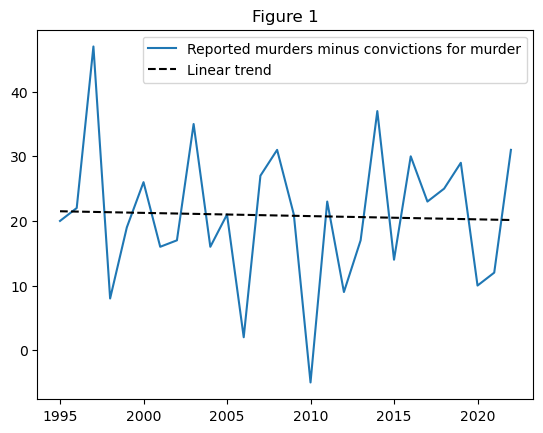

In [18]:
stationaritet = (anmeldte_proxy-straf_proxy).astype(int) #the difference between convicted and incidence rate, forcing object type to integer 
z = np.polyfit(tid_proxy, stationaritet, 1) # fitting trend line
p = np.poly1d(z)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(tid_proxy, stationaritet, label='Reported murders minus convictions for murder')
ax.plot(tid_proxy, p(tid_proxy), color='black', linestyle='--', label='Linear trend')
plt.title('Figure 1')
plt.legend()
plt.show()


## Explore each data set

In order to be able to **explore the raw data**, you may provide **static** and **interactive plots** to show important developments 

**Interactive plot** :

In [2]:
def plot_func():
    # Function that operates on data set
    pass

widgets.interact(plot_func, 
    # Let the widget interact with data through plot_func()    
); 


interactive(children=(Output(),), _dom_classes=('widget-interact',))

Explain what you see when moving elements of the interactive plot around. 

# Merge data sets

Now you create combinations of your loaded data sets. Remember the illustration of a (inner) **merge**:

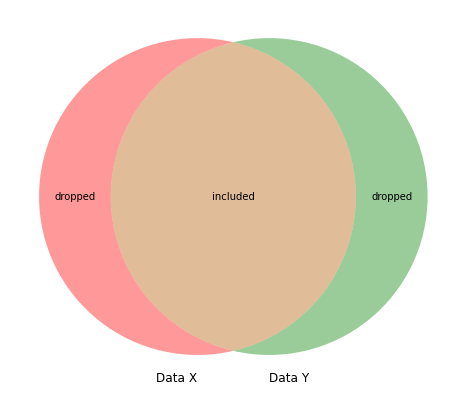

In [3]:
plt.figure(figsize=(15,7))
v = venn2(subsets = (4, 4, 10), set_labels = ('Data X', 'Data Y'))
v.get_label_by_id('100').set_text('dropped')
v.get_label_by_id('010').set_text('dropped' )
v.get_label_by_id('110').set_text('included')
plt.show()

Here we are dropping elements from both data set X and data set Y. A left join would keep all observations in data X intact and subset only from Y. 

Make sure that your resulting data sets have the correct number of rows and columns. That is, be clear about which observations are thrown away. 

**Note:** Don't make Venn diagrams in your own data project. It is just for exposition. 

# Analysis

To get a quick overview of the data, we show some **summary statistics** on a meaningful aggregation. 

MAKE FURTHER ANALYSIS. EXPLAIN THE CODE BRIEFLY AND SUMMARIZE THE RESULTS.

# Conclusion

ADD CONCISE CONLUSION.